In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%config Completer.use_jedi = False

# Keras의 pretrained model을 활용
* 해당 모델에 대한 자세한 학습을 하기보단 끌어와 사용하는 것에 초점을 맞춘다.
* pretrained 모델을 이용하면 우리가 custom model을 통해 가중치를 학습하고 모델을 사용하는 것이 아니라 기존에 있는 모델을 활용하는 것이 가능하다.

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 

# 입력 image의 크기를 resize 값만큼 추가. CIFAR10의 이미지가 32 by 32이라 model을 만들면 feature map의 사이즈가 작아진다.
# 이로 인해서 마지막 feature map의 사이즈가 1 by1로 나오는데 이로 인해 성능이 떨어지게 된다.
# 따라서 마지막 feature map의 크기를 hw가 버텨주는 선에서 최대로 키우는데 상한선인 64 by 64로 resize한다.
# 이로 인해 이미지의 화질이 떨어지는 문제가 생기지만 그럼에도 성능은 개선된다.
def get_resized_images(images, resize=64):
    image_cnt = images.shape[0]
    resized_images = np.zeros((images.shape[0], resize, resize, 3))
    for i in range(image_cnt):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image  # 기존 np.zeros로 인해 0들이 들어가 있으니까 그걸 채워준다.
    
    return resized_images  # 당연히 화질은 더 떨이진다. 

def create_model(image_size, model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(image_size, image_size, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':  # vgg16은 모델 사이즈가 그닥 크지 않아 dropout을 진행하지 않아도 된다. 나머진 channel 너무 많아.
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
        
    return model

2024-02-18 08:21:22.598488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 08:21:22.598586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 08:21:22.707047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

def do_cifar10_train_evaluation(image_size, model_name='vgg16'):
    set_random_seed(2021)
    # CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
        get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
    print('데이터 세트 shape:', tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)
    
    # 만약 image_size가 32보다 크면 이미지 크기 재조정. 
    if image_size > 32:
        tr_images = get_resized_images(tr_images)
        val_images = get_resized_images(val_images)
        test_images = get_resized_images(test_images)
    
    # 학습/검증/테스트용 ImageDataGenerator와 flow로 pipeline 생성. 
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255.0
    )
    valid_generator = ImageDataGenerator(rescale=1/255.0)
    test_generator = ImageDataGenerator(rescale=1/255.0)

    flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    flow_test_gen = train_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    
    # model_name 에 따른 모델 생성하고 모델 학습 및 검증 수행. 
    model = create_model(image_size= image_size,model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # callback 설정
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    history = model.fit(flow_tr_gen, epochs=40,  
                        validation_data=flow_val_gen,
                        callbacks=[rlr_cb, ely_cb], verbose=True)
    # 테스트 데이터 세트로 모델 성능 검증 
    evaluation_result = model.evaluate(flow_test_gen)
    print('테스트 데이터 세트 evaluation 결과:', evaluation_result)
    return history, evaluation_result


In [5]:
# image size를 32에서 64로 늘린 이유는 마지막에 만들어지는 feature map의 사이즈가 너무 작아서다.
# 물론 cifar10 데이터는 32by32라 화질은 떨어지겠지만 그럼에도 마지막 feature map 사이즈를 키우기 위해서
# 예전 custom model은 4 by 4로 했는데 왜 그럼 128 by 128로 안 하냐 싶기도 한데 이건 hw 제약으로 인해서 안 된다
# 만약 image_size를 64로 하려면 반드시 RAM이 여유분이 충분히 있는지 확인
# 결과적으로 우리가 예전에 만든 custom model보단 성능이 좋다.
# 학습 과정에서 결과가 흔들리는 이유는 모델에서 생성된 feature map이 1by1 사이즈로 너무 작기도 해서 안정성이 떨어진다.
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name='xception')

170498071/170498071 [==============================] - 17s 0us/step
데이터 세트 shape: (42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)
83683744/83683744 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 31, 31, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 31, 31, 32)           128       ['block1_conv1[0][0]']        
 alization)                                           

I0000 00:00:1708244541.910347      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


665/665 [==============================] - 93s 98ms/step - loss: 0.7329 - accuracy: 0.7591 - val_loss: 0.4978 - val_accuracy: 0.8412 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 63s 94ms/step - loss: 0.4054 - accuracy: 0.8672 - val_loss: 0.4170 - val_accuracy: 0.8697 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 63s 94ms/step - loss: 0.3041 - accuracy: 0.9002 - val_loss: 0.4100 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 63s 94ms/step - loss: 0.2574 - accuracy: 0.9161 - val_loss: 0.3121 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 63s 94ms/step - loss: 0.2212 - accuracy: 0.9276 - val_loss: 0.3862 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 63s 95ms/step - loss: 0.1677 - accuracy: 0.9446 - val_loss: 0.3939 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 63s 94ms/step -

In [6]:
print('테스트 데이터세트 검증 결과:', evaluation_result)

테스트 데이터세트 검증 결과: [0.4022238552570343, 0.9297000169754028]


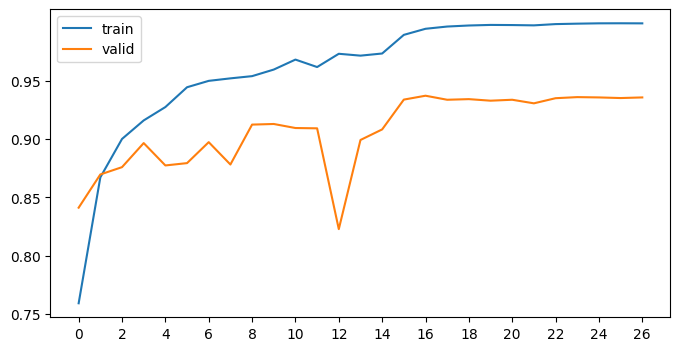

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)